#### Introduction
In this article, I'm demonstrating how to back-test using python on a simple moving average strategy. It is extremely difficult to predict stock market prices, but a lot of insight can be inferred by transforming the stock price variable. In this example, we explore the moving average, which is a pretty good momentum indicator. Momentum is pretty mean-reverting and might provide opportunities to BUY LOW and SELL HIGH.

#### Steps
1. Importing necessary libraries
2. Downloading OHLCV Data
3. Building the Data Frame
4. Event driven testing
5. Results
6. Conclusion

#### Step 1. Importing necessary libraries

In [249]:
# Ignore printing all warnings
import warnings
warnings.filterwarnings('ignore')

import nsepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt

#### Step 2. Downloading OHLCV Data

In [250]:
# downloading data
_days = 1200
_end = dt.today()
_start = end - pd.Timedelta(days=_days)
data = nsepy.get_history(symbol="RELIANCE", start=_start, end=_end)

#### Step 3. Building the Data Frame
So what is the intuition here? Moving averages are a great way to build momentum based strategies. If the current price is more than the average price for the last couple of days, it means that, the stock is overvalued and correction is expected. The same holds true for when the current price is below the moving average price, the stock is undervalued and might have a correction soon.

So, the strategy here would be to go long when the current price is below the moving average. For this example we will consider a 27 day moving average.

In [252]:
moving_average_window = 27

# readjusting data Frame
data = data[["Close"]]

# creating ** moving average
data["ma20"] = data["Close"].\
                rolling(window=moving_average_window).mean()

#calculating daily returns
data["daily returns"] = np.log(data["Close"] / data["Close"].shift(1))


data["position"] = [0] * len(data)
data.reset_index(inplace=True)
data = data.drop(["index"], axis=1)


pos_exit = False
pos = "N"

std = round(data["daily returns"].std(),4)
mean = round(data["daily returns"].mean(),4)

print("Std on daily returns  :", std)
print("Mean on daily returns :", mean,"\n")

print(data.head(7))

Std on daily returns  : 0.0217
Mean on daily returns : 0.0009 

     Close  ma20  daily returns  position
0  1231.70   NaN            NaN         0
1  1205.10   NaN      -0.021833         0
2  1122.25   NaN      -0.071227         0
3  1048.85   NaN      -0.067641         0
4  1109.40   NaN       0.056125         0
5  1090.05   NaN      -0.017596         0
6  1102.10   NaN       0.010994         0


#### Step 4. Event driven back-testing
In this step, an iteration takes place over daily data. The moving average data column is used to make the decision to either go long or short and is stored in the positions data column. 

In [254]:
# Event driven testing
for i in range(1, len(data)):
    # Signal to go short and reset position
    if pos_exit:
        pos_exit = False
        pos = "N"
        continue

    # going long, if return goes beyond lower bound 
    # (1 standard deviation). The asumption here is 
    # that the stock will revert back to its mean value
    if data["Close"][i] < ((1 - std) * data["ma20"][i]):
        data.at[i, "position"] = 1
        pos = "L"


    # scenario if return in between lower and upper bounds
    if pos == "L":
        data.at[i, "position"] = 1
    
    # updating strategy returns
    data["strategy returns"] = data["daily returns"] \
    * data["position"]

    # exiting if the strategy return drops by 3%
    if data["strategy returns"][i] < -0.03:
        data.at[i, "position"] = 0
        pos_exit = True 

data.tail(10)

,Close,ma20,daily returns,position,strategy returns
805,2368.15,2395.814815,0.003829,1,0.003829
806,2403.85,2392.514815,0.014963,1,0.014963
807,2458.10,2394.200000,0.022317,1,0.022317
808,2469.60,2395.240741,0.004668,1,0.004668
809,2416.50,2395.651852,-0.021736,1,-0.021736
810,2436.00,2394.503704,0.008037,1,0.008037
811,2438.00,2392.842593,0.000821,1,0.000821
812,2455.55,2394.594444,0.007173,1,0.007173
813,2521.10,2400.464815,0.026345,1,0.026345
814,2535.30,2406.148148,0.005617,1,0.005617


#### Step 5. Results

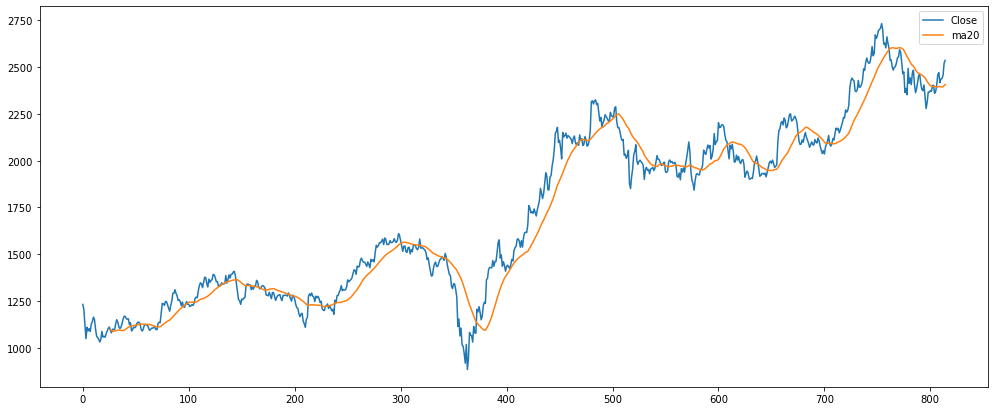

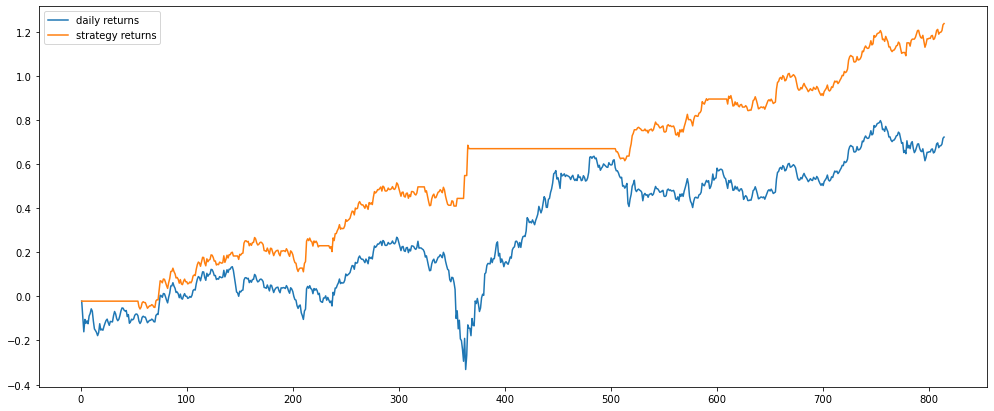

In [255]:
# taking positions after one day of signals being generated
data["position"].shift(1)

# plotting
data[["Close","ma20"]].plot(figsize = (17,7))
data[["daily returns", "strategy returns"]].cumsum().\
plot(figsize = (17,7))
plt.show()

#### Step 6. Conclusion

In [256]:
print("Buy and hold returns =",\
      round(list(data["daily returns"].cumsum())[-1],4)*100,"%")
print("Strategy returns =", \
      round(list(data["strategy returns"].cumsum())[-1],4)*100,"%")

Buy and hold returns = 72.19 %
Strategy returns = 123.64 %


+ The stocks, if were bought and held would have returned 72% of the initial investment over the 800 working days.
+ The strategy returned 125% of the initial investment.
+ Please note, the strategy did not implement transaction costs, which will vary the results entirely
+ If a backtest performs well on the historical data, it doesn't assure it will give the same results on future data. This is evident in the fact that, by changing the number of days, the returns might vary significantly. It could also depend on the overall trend observed in stock during a certain time period.
+ It is better to implement strategies on a portfolio of stocks that are uncorrelated as it reduces the risk due to diversification and hedging.
+ The above strategy can be optimized and more sources of alpha and risk measures can be added to increase returns, Sharpe ratio, and reduce risks.

The code snippets can be found at: https://github.com/karthikramx/Backtesting-Buy-Low-Sell-High